In [31]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge
from scipy import stats
from sklearn.model_selection import StratifiedKFold
from scipy.stats import sem
import random
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# Dataset

In [32]:
jerks_path = "Dataset/Human_Likeness_Features/mean_jerk_values.csv"
XX_jerks = pd.read_csv(jerks_path) # With Spine joint and Name of "Cond/StudySeq"

accels_path = "Dataset/Human_Likeness_Features/mean_acceleration_values.csv"
XX_accels = pd.read_csv(accels_path) # With Spine joint and Name of "Cond/StudySeq"

pairwise_path = "Dataset/Human_Likeness_Features/mean_pairwise_joint_distances.csv"
XX_pairwise = pd.read_csv(pairwise_path) # With Spine joint and Name of "Cond/StudySeq"
XX_pairwise.drop(XX_pairwise.columns[range(1,15)], axis=1, inplace=True) # Without Spine Joint but with Name of "Cond/StudySeq"

labels_path = "Dataset/Human_Likeness_Labels/mean_opinion_scores.csv"
YY = pd.read_csv(labels_path) # # With Name of "Cond/StudySeq"

In [33]:
XY = XX_jerks.join(YY, lsuffix="_jerks", rsuffix="_YY")
XY = XY.join(XX_accels, rsuffix='_accels')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_accels'})
XY = XY.join(XX_pairwise, rsuffix='_pairwise')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_pairwise'})

# Drop the Names of "Cond/StudySeq" and remaining information relating to the "Spine" joint
XY.drop(['Unnamed: 0_jerks','Unnamed: 0_YY','Unnamed: 0_accels', 'Unnamed: 0_pairwise', 'Spine', 'Spine_accels'], axis=1, inplace=True)

rename_dict = dict(zip(XY.columns[0:14], XY.columns[0:14] + '_jerks'))
XY = XY.rename(columns=rename_dict)

print(XY.shape) # Jerk for 14 joints + Acceleration for 14 joints + 14 choose 2 pairwise distance + Label for MOS = 120

(320, 120)


In [34]:
XX = XY.drop(['Mean_Human_Likeness_Score'], axis=1, inplace=False)
bad_features = ['LeftShoulder_vs_LeftArm', 'LeftArm_vs_LeftForeArm', 'LeftForeArm_vs_LeftHand',
                'RightShoulder_vs_RightArm', 'RightArm_vs_RightForeArm','RightForeArm_vs_RightHand']
XX.drop(bad_features, axis=1, inplace=True)
YY = XY.loc[:,'Mean_Human_Likeness_Score']
XX = np.log(XX)
print(XX.shape)
print(YY.shape)

(320, 113)
(320,)


In [35]:
index_to_reduce = [x for x in range(0,20)] + [x for x in range (80,100)] + [x for x in range(200,220)]
XX = XX.iloc[index_to_reduce,:]
YY_genea = YY[index_to_reduce]
YY_genea.index = np.arange(0, len(index_to_reduce))
YY_survey = pd.read_csv('Dataset/Human_Likeness_Labels/survey_labels.csv').loc[:,'Mean_Human_Likeness_Score']
YY_combined = pd.read_csv('Dataset/Human_Likeness_Labels/combined_labels.csv').loc[:,'Mean_Human_Likeness_Score']

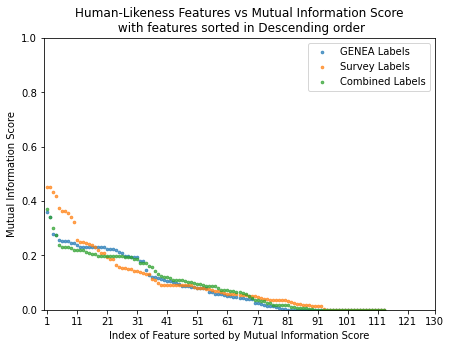

In [36]:
plt.figure(figsize=(7,5))
scores = mutual_info_regression(XX, YY_genea, discrete_features = False)
plt.scatter(np.arange(1,114), np.flip(np.sort(scores)), s=7, alpha = 0.7, label='GENEA Labels')
scores = mutual_info_regression(XX, YY_survey, discrete_features = False)
plt.scatter(np.arange(1,114), np.flip(np.sort(scores)), s=7, alpha = 0.7, label='Survey Labels')
scores = mutual_info_regression(XX, YY_combined, discrete_features = False)
plt.scatter(np.arange(1,114), np.flip(np.sort(scores)), s=7, alpha = 0.7, label='Combined Labels')
plt.xlim(0,114)
plt.ylim(0,1)
plt.title('Human-Likeness Features vs Mutual Information Score\n with features sorted in Descending order')
plt.xlabel('Index of Feature sorted by Mutual Information Score')
plt.ylabel('Mutual Information Score')
plt.xticks(np.append(np.arange(1,131,10),130))
plt.legend()

In [37]:
XX_train, XX_test, YY_train_genea, YY_test_genea = train_test_split(XX, YY_genea, test_size=0.2)

In [38]:
train_idx = list(YY_train_genea.index)
test_idx = list(YY_test_genea.index)
YY_train_survey, YY_test_survey = YY_survey.loc[train_idx], YY_survey.loc[test_idx]
YY_train_combined, YY_test_combined = YY_combined.loc[train_idx], YY_combined.loc[test_idx]

In [39]:
def validation_curve(model_name, model, XX, YY, param_grid, log_bool, extra_string, xticks):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    outer_val_mse = []
    outer_train_mse = []
    folds = outer_loop_cv.split(XX)
    count = 1
    for train, test in folds:
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        YY_train = YY_train.values.flatten()
        
        cv_model = GridSearchCV(estimator = model, param_grid = param_grid, scoring = "neg_mean_squared_error", 
                                    cv = KFold(n_splits = 5, shuffle = True), return_train_score=True)
        cv_model.fit(XX_train, YY_train)
        
        train_mse = -1 * cv_model.cv_results_["mean_train_score"]
        val_mse = -1 * cv_model.cv_results_["mean_test_score"]
        
        outer_train_mse = outer_train_mse + [train_mse]
        outer_val_mse = outer_val_mse + [val_mse]
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
        
    mean_train_mse = np.mean(np.asarray(outer_train_mse), axis=0)
    mean_val_mse = np.mean(np.asarray(outer_val_mse), axis=0)
    
    train_mse_sem = sem(np.asarray(outer_train_mse), axis=0)
    val_mse_sem = sem(np.asarray(outer_val_mse), axis=0)
    
    param_list = list(np.concatenate(list(param_grid.values())).flat)
    
    plt.figure(figsize = (6,4))
    plt.plot(param_list, mean_train_mse, label='Training Set MSE')
    plt.fill_between(param_list, mean_train_mse - train_mse_sem, mean_train_mse + train_mse_sem, alpha=0.5)
    plt.plot(param_list, mean_val_mse, label='Validation Set MSE')
    plt.fill_between(param_list, mean_val_mse - val_mse_sem, mean_val_mse + val_mse_sem, alpha=0.5)
    if log_bool == True:
        plt.xscale('log')
    plt.xlim(min(param_list),max(param_list))
    plt.xticks(xticks)
    plt.ylim(0, max([max(mean_train_mse), max(mean_val_mse)]) + max([max(train_mse_sem), max(val_mse_sem)]))
    plt.ylabel('MSE')
    plt.xlabel(list(param_grid.keys())[0])
    plt.title(model_name + ' performance on varying ' + list(param_grid.keys())[0] + extra_string)
    plt.legend()
    

In [40]:
# Model name is just the type of algorithm e.g. Linear Regression or kNN
def predicted_vs_true(model_name, model, XX, YY):
    n_splits = 5
    outer_loop_cv = KFold(n_splits = n_splits, shuffle = True)
    folds = outer_loop_cv.split(XX)
    count = 1
    YY_train_true = []
    YY_train_preds = []
    YY_preds = []
    YY_true = []
    for train, test in folds:
        XX_train = XX.iloc[train]
        YY_train = YY.iloc[train]
        XX_test= XX.iloc[test]
        YY_test = YY.iloc[test]
        YY_train, YY_test = YY_train.values.flatten(), YY_test.values.flatten()
        
        model.fit(XX_train, YY_train)
        
        YY_train_preds = YY_train_preds + list(model.predict(XX_train))
        YY_train_true = YY_train_true + list(YY_train)
        
        YY_pred = model.predict(XX_test)
        
        YY_true = YY_true + list(YY_test)
        YY_preds = YY_preds + list(YY_pred)
        print('Fold ', count, '/', n_splits, ' Complete.')
        count = count + 1
    
    
    m, b = np.polyfit(YY_preds, YY_true, 1)
    x = np.arange(0,101)
    y = np.arange(0,101)
    
    plt.figure(figsize = (7,7))
    plt.scatter(YY_preds, YY_true, s=7.5, alpha=0.8, label='Predictions')
    plt.plot(x, y*m + b, '-c', label="Regression Line for predictions")
    plt.plot(x, y, "-k", label="Regression Line for p=1", alpha=0.5)
    plt.title("Predictions of " + model_name + " Model on Test Set")
    plt.ylabel("True Human-Likeness")
    plt.xlabel("Predicted Human-Likeness")
    plt.xticks(np.linspace(0,100,11))
    plt.yticks(np.linspace(0,100,11))
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.legend()

    rho, pval = stats.spearmanr(YY_true, YY_preds)
    print("Pearson Correlation Coefficient =", rho)
    print("Test Mean Squared Error = ", mean_squared_error(YY_true, YY_preds, squared=True))
    print("Train Mean Squared Error = ", mean_squared_error(YY_train_true, YY_train_preds, squared=True))

# SVR - GENEA Labels

Grid Search Cross Validation for Hyperparameter Tuning

In [53]:
start_time = time.time()

param_grid = {"C": np.logspace(-3, 6, num=10), "gamma": np.logspace(-9, 4, num=14), "epsilon": np.logspace(-3, 6, num=10)}

svr = GridSearchCV(estimator = SVR(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error")

svr.fit(XX_train, YY_train_genea)

svr_init_params = svr.best_params_

print("Time taken: ", time.time() - start_time)

Time taken:  47.097445487976074


In [54]:
print(svr.best_params_)

{'C': 1000.0, 'epsilon': 10.0, 'gamma': 0.01}


Finer Hyperparameter tuning

Tuning epsilon

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  105.72699999809265


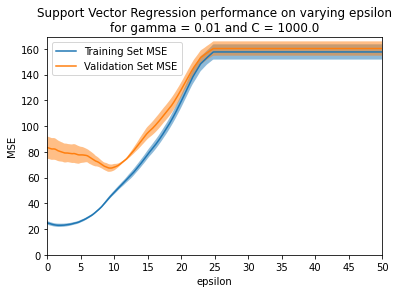

In [55]:
start_time = time.time()
svr = SVR(kernel = "rbf", gamma = svr_init_params['gamma'], C = svr_init_params['C'])
extra_string = '\nfor gamma = ' + str(svr_init_params['gamma']) + ' and C = ' + str(svr_init_params['C'])
param_grid = {"epsilon": np.linspace(0, 50, num=500)}
validation_curve('Support Vector Regression', svr, XX, YY_genea, param_grid, False, extra_string, np.linspace(0, 50, num=11))
print("Time taken: ", time.time() - start_time)

Tuning gamma

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  108.22255516052246


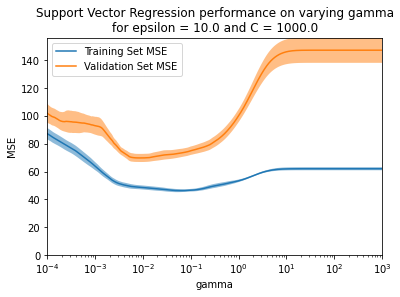

In [56]:
start_time = time.time()
svr = SVR(kernel = "rbf", epsilon = svr_init_params['epsilon'], C = svr_init_params['C'])
extra_string = '\nfor epsilon = ' + str(svr_init_params['epsilon']) + ' and C = ' + str(svr_init_params['C'])
param_grid = {"gamma": np.logspace(-4, 3, num=500)}
validation_curve('Support Vector Regression', svr, XX, YY_genea, param_grid, True, extra_string, np.logspace(-4, 3, num=8))
print("Time taken: ", time.time() - start_time)

Tuning C

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  105.78616261482239


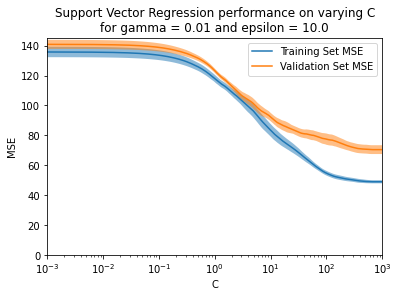

In [57]:
start_time = time.time()
svr = SVR(kernel = "rbf", gamma = svr_init_params['gamma'], epsilon = svr_init_params['epsilon'])
extra_string = '\nfor gamma = ' + str(svr_init_params['gamma']) + ' and epsilon = ' + str(svr_init_params['epsilon'])
param_grid = {"C": np.logspace(-3, 3, num=500)}
validation_curve('Support Vector Regression', svr, XX, YY_genea, param_grid, True, extra_string, np.logspace(-3, 3, num=7))
print("Time taken: ", time.time() - start_time)

Predicted vs True

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.6306196165601556
Test Mean Squared Error =  89.51098172904705
Train Mean Squared Error =  26.696016831355582
Time taken:  1169.9592370986938


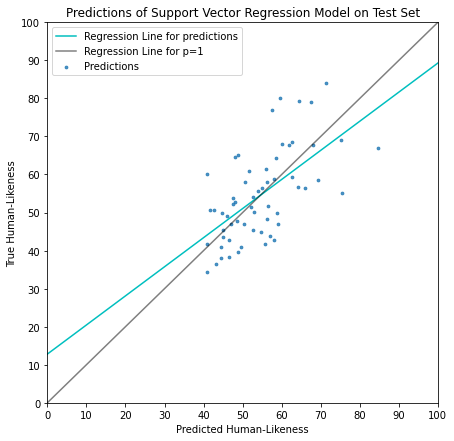

In [58]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"C": np.logspace(-3, 4, num=20), "gamma": np.logspace(-4, 2, num=20), "epsilon": np.linspace(0, 50, num=20)}
svr = GridSearchCV(estimator = SVR(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Support Vector Regression', svr, XX, YY_genea)
print("Time taken: ", time.time() - start_time)

# SVR - Survey Labels

In [59]:
start_time = time.time()

param_grid = {"C": np.logspace(-3, 6, num=10), "gamma": np.logspace(-9, 4, num=14), "epsilon": np.logspace(-3, 6, num=10)}

svr = GridSearchCV(estimator = SVR(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error")

svr.fit(XX_train, YY_train_survey)

svr_init_params = svr.best_params_

print("Time taken: ", time.time() - start_time)

Time taken:  43.40393900871277


Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  102.05411052703857


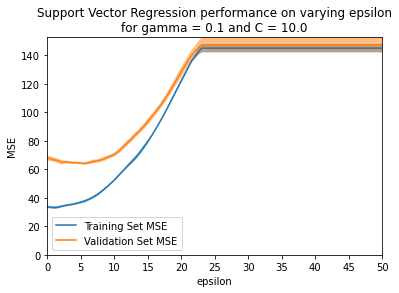

In [60]:
start_time = time.time()
svr = SVR(kernel = "rbf", gamma = svr_init_params['gamma'], C = svr_init_params['C'])
extra_string = '\nfor gamma = ' + str(svr_init_params['gamma']) + ' and C = ' + str(svr_init_params['C'])
param_grid = {"epsilon": np.linspace(0, 50, num=500)}
validation_curve('Support Vector Regression', svr, XX, YY_survey, param_grid, False, extra_string, np.linspace(0, 50, num=11))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  108.9207489490509


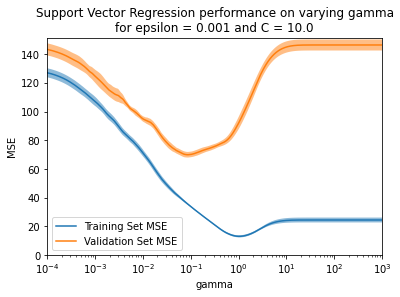

In [61]:
start_time = time.time()
svr = SVR(kernel = "rbf", epsilon = svr_init_params['epsilon'], C = svr_init_params['C'])
extra_string = '\nfor epsilon = ' + str(svr_init_params['epsilon']) + ' and C = ' + str(svr_init_params['C'])
param_grid = {"gamma": np.logspace(-4, 3, num=500)}
validation_curve('Support Vector Regression', svr, XX, YY_survey, param_grid, True, extra_string, np.logspace(-4, 3, num=8))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  111.11488127708435


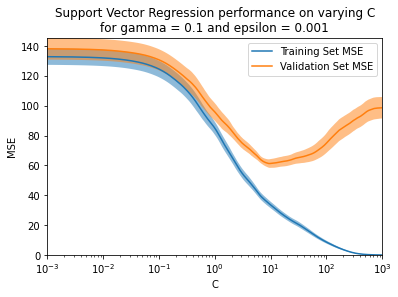

In [62]:
start_time = time.time()
svr = SVR(kernel = "rbf", gamma = svr_init_params['gamma'], epsilon = svr_init_params['epsilon'])
extra_string = '\nfor gamma = ' + str(svr_init_params['gamma']) + ' and epsilon = ' + str(svr_init_params['epsilon'])
param_grid = {"C": np.logspace(-3, 3, num=500)}
validation_curve('Support Vector Regression', svr, XX, YY_survey, param_grid, True, extra_string, np.logspace(-3, 3, num=7))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.7365057329337965
Test Mean Squared Error =  62.02813563936335
Train Mean Squared Error =  25.51062091300117
Time taken:  1262.6583504676819


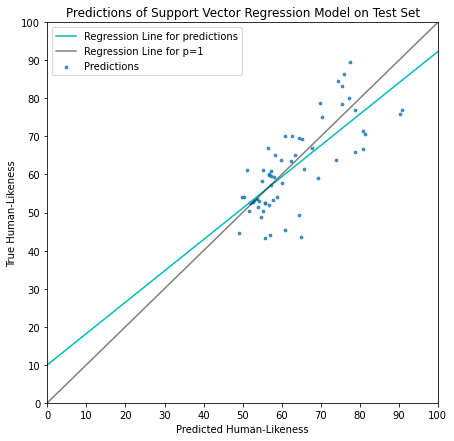

In [63]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"C": np.logspace(-3, 4, num=20), "gamma": np.logspace(-4, 2, num=20), "epsilon": np.linspace(0, 50, num=20)}
svr = GridSearchCV(estimator = SVR(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Support Vector Regression', svr, XX, YY_survey)
print("Time taken: ", time.time() - start_time)

# SVR - Combined Labels

In [64]:
start_time = time.time()

param_grid = {"C": np.logspace(-3, 6, num=10), "gamma": np.logspace(-9, 4, num=14), "epsilon": np.logspace(-3, 6, num=10)}

svr = GridSearchCV(estimator = SVR(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error")

svr.fit(XX_train, YY_train_combined)

svr_init_params = svr.best_params_

print("Time taken: ", time.time() - start_time)

Time taken:  43.50252723693848


Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  103.40042233467102


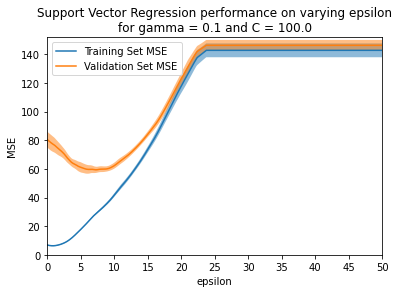

In [65]:
start_time = time.time()
svr = SVR(kernel = "rbf", gamma = svr_init_params['gamma'], C = svr_init_params['C'])
extra_string = '\nfor gamma = ' + str(svr_init_params['gamma']) + ' and C = ' + str(svr_init_params['C'])
param_grid = {"epsilon": np.linspace(0, 50, num=500)}
validation_curve('Support Vector Regression', svr, XX, YY_combined, param_grid, False, extra_string, np.linspace(0, 50, num=11))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  104.95404171943665


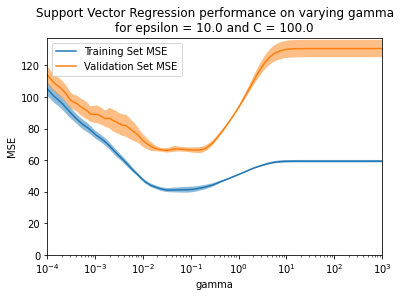

In [66]:
start_time = time.time()
svr = SVR(kernel = "rbf", epsilon = svr_init_params['epsilon'], C = svr_init_params['C'])
extra_string = '\nfor epsilon = ' + str(svr_init_params['epsilon']) + ' and C = ' + str(svr_init_params['C'])
param_grid = {"gamma": np.logspace(-4, 3, num=500)}
validation_curve('Support Vector Regression', svr, XX, YY_combined, param_grid, True, extra_string, np.logspace(-4, 3, num=8))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  113.34861087799072


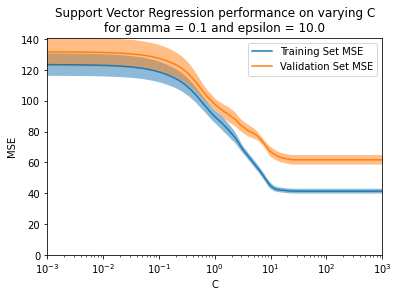

In [67]:
start_time = time.time()
svr = SVR(kernel = "rbf", gamma = svr_init_params['gamma'], epsilon = svr_init_params['epsilon'])
extra_string = '\nfor gamma = ' + str(svr_init_params['gamma']) + ' and epsilon = ' + str(svr_init_params['epsilon'])
param_grid = {"C": np.logspace(-3, 3, num=500)}
validation_curve('Support Vector Regression', svr, XX, YY_combined, param_grid, True, extra_string, np.logspace(-3, 3, num=7))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.67757710475132
Test Mean Squared Error =  71.55367893035505
Train Mean Squared Error =  27.898904214270882
Time taken:  1269.5787937641144


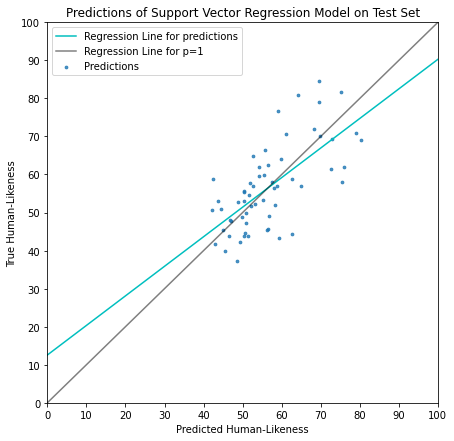

In [68]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"C": np.logspace(-3, 4, num=20), "gamma": np.logspace(-4, 2, num=20), "epsilon": np.linspace(0, 50, num=20)}
svr = GridSearchCV(estimator = SVR(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Support Vector Regression', svr, XX, YY_combined)
print("Time taken: ", time.time() - start_time)

# Linear Regression - GENEA Labels

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.2311197554876355
Test Mean Squared Error =  595.3229056094835
Train Mean Squared Error =  3.94798272155247e-24
Time taken:  0.1436166763305664


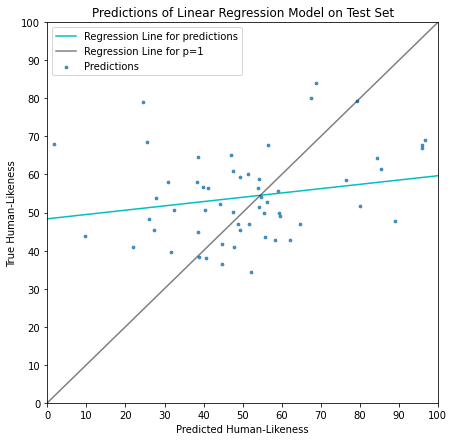

In [41]:
start_time = time.time()
predicted_vs_true('Linear Regression', LinearRegression(), XX, YY_genea)
print("Time taken: ", time.time() - start_time)

# Linear Regression - Survey Labels

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.16266759330671363
Test Mean Squared Error =  573.1973923889337
Train Mean Squared Error =  5.602480051460039e-24
Time taken:  0.10622549057006836


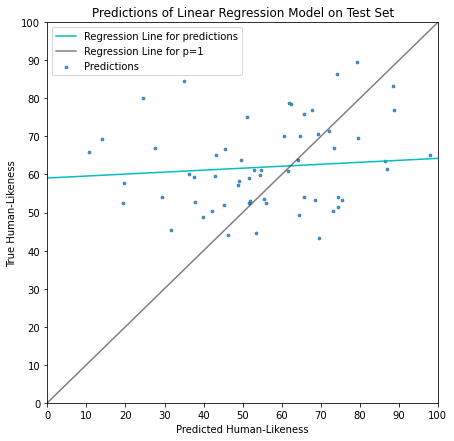

In [42]:
start_time = time.time()
predicted_vs_true('Linear Regression', LinearRegression(), XX, YY_survey)
print("Time taken: ", time.time() - start_time)

# Linear Regression - Combined Labels

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.32092247846624067
Test Mean Squared Error =  386.4055747032945
Train Mean Squared Error =  5.166295085954731e-24
Time taken:  0.11968016624450684


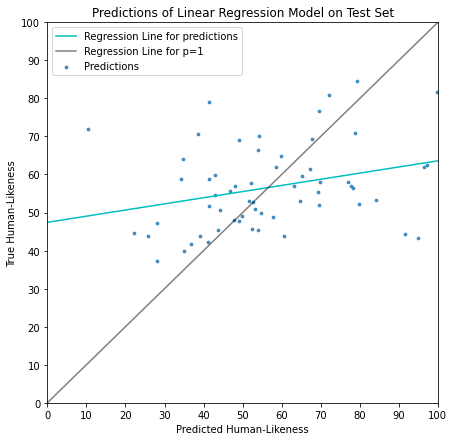

In [43]:
start_time = time.time()
predicted_vs_true('Linear Regression', LinearRegression(), XX, YY_combined)
print("Time taken: ", time.time() - start_time)

# Ridge Regression - GENEA Labels

Tuning alpha

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  223.95946550369263


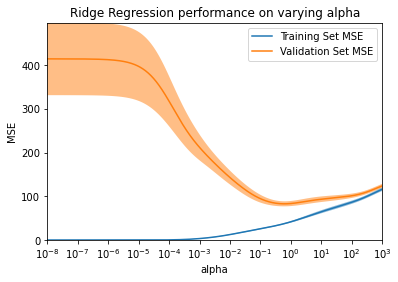

In [69]:
start_time = time.time()
validation_curve('Ridge Regression', Ridge(), XX, YY_genea, {"alpha": np.logspace(-8,3, 1000)}, True, '', np.logspace(-8,3,12))
print("Time taken: ", time.time() - start_time)

Predicted vs True

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.5779938871908865
Test Mean Squared Error =  97.35210699002727
Train Mean Squared Error =  33.218747413457926
Time taken:  161.20095348358154


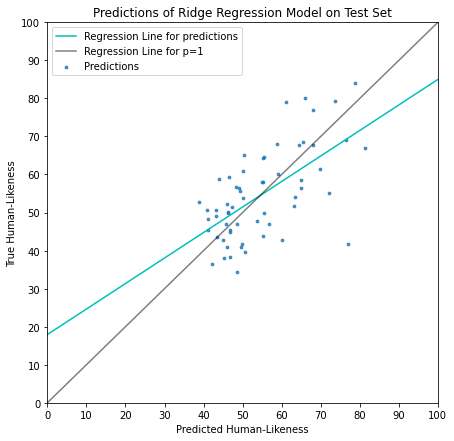

In [70]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"alpha": np.logspace(-8,3, 1000)}
ridge_model = GridSearchCV(estimator = Ridge(), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Ridge Regression', ridge_model, XX, YY_genea)
print("Time taken: ", time.time() - start_time)

# Ridge Regression - Survey Labels

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  231.8502459526062


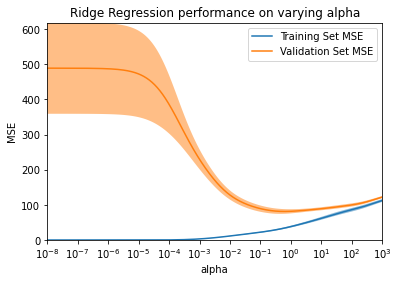

In [71]:
start_time = time.time()
validation_curve('Ridge Regression', Ridge(), XX, YY_survey, {"alpha": np.logspace(-8,3, 1000)}, True, '', np.logspace(-8,3,12))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.6841264344399195
Test Mean Squared Error =  69.76127497706551
Train Mean Squared Error =  35.96937507919305
Time taken:  254.41972160339355


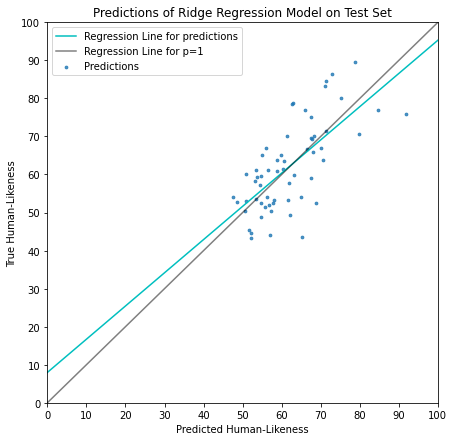

In [72]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"alpha": np.logspace(-8,3, 1000)}
ridge_model = GridSearchCV(estimator = Ridge(), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Ridge Regression', ridge_model, XX, YY_survey)
print("Time taken: ", time.time() - start_time)

# Ridge Regression - Combined Labels

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  295.84621500968933


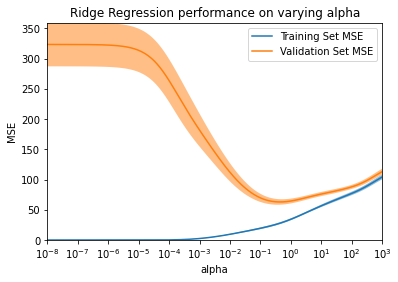

In [73]:
start_time = time.time()
validation_curve('Ridge Regression', Ridge(), XX, YY_combined, {"alpha": np.logspace(-8,3, 1000)}, True, '', np.logspace(-8,3,12))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.6524590163934427
Test Mean Squared Error =  82.83570142330356
Train Mean Squared Error =  37.57185665878437
Time taken:  164.83299112319946


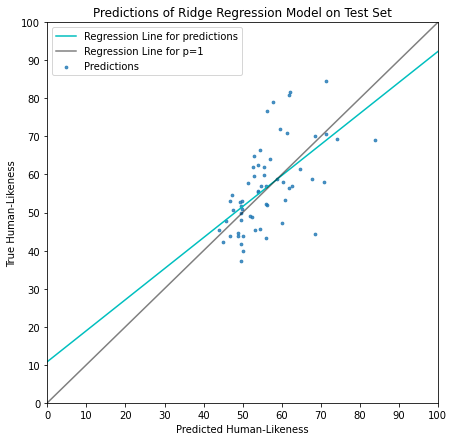

In [74]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"alpha": np.logspace(-8,3, 1000)}
ridge_model = GridSearchCV(estimator = Ridge(), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Ridge Regression', ridge_model, XX, YY_combined)
print("Time taken: ", time.time() - start_time)

# Kernel Ridge Regression - GENEA Labels

Grid Search for hyperparameter intialisations

In [75]:
start_time = time.time()

param_grid = {"alpha": np.logspace(-10,5, 16), "gamma": np.logspace(-10, 5, 16)}
kfolds = KFold(n_splits = 5, shuffle = True)
krr = GridSearchCV(estimator = KernelRidge(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv=kfolds, verbose = 3)
krr.fit(XX_train, YY_train_genea)

krr_init_params = krr.best_params_
print("Time taken: ", time.time() - start_time)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV 1/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.2s
[CV 2/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 3/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 4/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 5/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 1/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 2/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 3/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 4/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 5/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 1/5] END .......................alpha=1e-10, gamma=1e-08; total time=   0.0s
[CV 2/5] END .......................alpha=1e-

[CV 5/5] END ........................alpha=1e-09, gamma=0.01; total time=   0.0s
[CV 1/5] END .........................alpha=1e-09, gamma=0.1; total time=   0.0s
[CV 2/5] END .........................alpha=1e-09, gamma=0.1; total time=   0.0s
[CV 3/5] END .........................alpha=1e-09, gamma=0.1; total time=   0.0s
[CV 4/5] END .........................alpha=1e-09, gamma=0.1; total time=   0.0s
[CV 5/5] END .........................alpha=1e-09, gamma=0.1; total time=   0.0s
[CV 1/5] END .........................alpha=1e-09, gamma=1.0; total time=   0.0s
[CV 2/5] END .........................alpha=1e-09, gamma=1.0; total time=   0.0s
[CV 3/5] END .........................alpha=1e-09, gamma=1.0; total time=   0.0s
[CV 4/5] END .........................alpha=1e-09, gamma=1.0; total time=   0.0s
[CV 5/5] END .........................alpha=1e-09, gamma=1.0; total time=   0.0s
[CV 1/5] END ........................alpha=1e-09, gamma=10.0; total time=   0.0s
[CV 2/5] END ...............

[CV 3/5] END .......................alpha=1e-07, gamma=1e-09; total time=   0.0s
[CV 4/5] END .......................alpha=1e-07, gamma=1e-09; total time=   0.0s
[CV 5/5] END .......................alpha=1e-07, gamma=1e-09; total time=   0.0s
[CV 1/5] END .......................alpha=1e-07, gamma=1e-08; total time=   0.0s
[CV 2/5] END .......................alpha=1e-07, gamma=1e-08; total time=   0.0s
[CV 3/5] END .......................alpha=1e-07, gamma=1e-08; total time=   0.0s
[CV 4/5] END .......................alpha=1e-07, gamma=1e-08; total time=   0.0s
[CV 5/5] END .......................alpha=1e-07, gamma=1e-08; total time=   0.0s
[CV 1/5] END .......................alpha=1e-07, gamma=1e-07; total time=   0.0s
[CV 2/5] END .......................alpha=1e-07, gamma=1e-07; total time=   0.0s
[CV 3/5] END .......................alpha=1e-07, gamma=1e-07; total time=   0.0s
[CV 4/5] END .......................alpha=1e-07, gamma=1e-07; total time=   0.0s
[CV 5/5] END ...............

[CV 3/5] END .........................alpha=1e-06, gamma=1.0; total time=   0.0s
[CV 4/5] END .........................alpha=1e-06, gamma=1.0; total time=   0.0s
[CV 5/5] END .........................alpha=1e-06, gamma=1.0; total time=   0.0s
[CV 1/5] END ........................alpha=1e-06, gamma=10.0; total time=   0.0s
[CV 2/5] END ........................alpha=1e-06, gamma=10.0; total time=   0.0s
[CV 3/5] END ........................alpha=1e-06, gamma=10.0; total time=   0.0s
[CV 4/5] END ........................alpha=1e-06, gamma=10.0; total time=   0.0s
[CV 5/5] END ........................alpha=1e-06, gamma=10.0; total time=   0.0s
[CV 1/5] END .......................alpha=1e-06, gamma=100.0; total time=   0.0s
[CV 2/5] END .......................alpha=1e-06, gamma=100.0; total time=   0.0s
[CV 3/5] END .......................alpha=1e-06, gamma=100.0; total time=   0.0s
[CV 4/5] END .......................alpha=1e-06, gamma=100.0; total time=   0.0s
[CV 5/5] END ...............

[CV 5/5] END ......................alpha=0.0001, gamma=1e-08; total time=   0.0s
[CV 1/5] END ......................alpha=0.0001, gamma=1e-07; total time=   0.0s
[CV 2/5] END ......................alpha=0.0001, gamma=1e-07; total time=   0.0s
[CV 3/5] END ......................alpha=0.0001, gamma=1e-07; total time=   0.0s
[CV 4/5] END ......................alpha=0.0001, gamma=1e-07; total time=   0.0s
[CV 5/5] END ......................alpha=0.0001, gamma=1e-07; total time=   0.0s
[CV 1/5] END ......................alpha=0.0001, gamma=1e-06; total time=   0.0s
[CV 2/5] END ......................alpha=0.0001, gamma=1e-06; total time=   0.0s
[CV 3/5] END ......................alpha=0.0001, gamma=1e-06; total time=   0.0s
[CV 4/5] END ......................alpha=0.0001, gamma=1e-06; total time=   0.0s
[CV 5/5] END ......................alpha=0.0001, gamma=1e-06; total time=   0.0s
[CV 1/5] END ......................alpha=0.0001, gamma=1e-05; total time=   0.0s
[CV 2/5] END ...............

[CV 3/5] END ........................alpha=0.001, gamma=10.0; total time=   0.0s
[CV 4/5] END ........................alpha=0.001, gamma=10.0; total time=   0.0s
[CV 5/5] END ........................alpha=0.001, gamma=10.0; total time=   0.0s
[CV 1/5] END .......................alpha=0.001, gamma=100.0; total time=   0.0s
[CV 2/5] END .......................alpha=0.001, gamma=100.0; total time=   0.0s
[CV 3/5] END .......................alpha=0.001, gamma=100.0; total time=   0.0s
[CV 4/5] END .......................alpha=0.001, gamma=100.0; total time=   0.0s
[CV 5/5] END .......................alpha=0.001, gamma=100.0; total time=   0.0s
[CV 1/5] END ......................alpha=0.001, gamma=1000.0; total time=   0.0s
[CV 2/5] END ......................alpha=0.001, gamma=1000.0; total time=   0.0s
[CV 3/5] END ......................alpha=0.001, gamma=1000.0; total time=   0.0s
[CV 4/5] END ......................alpha=0.001, gamma=1000.0; total time=   0.0s
[CV 5/5] END ...............

[CV 2/5] END .........................alpha=0.1, gamma=1e-06; total time=   0.0s
[CV 3/5] END .........................alpha=0.1, gamma=1e-06; total time=   0.0s
[CV 4/5] END .........................alpha=0.1, gamma=1e-06; total time=   0.0s
[CV 5/5] END .........................alpha=0.1, gamma=1e-06; total time=   0.0s
[CV 1/5] END .........................alpha=0.1, gamma=1e-05; total time=   0.0s
[CV 2/5] END .........................alpha=0.1, gamma=1e-05; total time=   0.0s
[CV 3/5] END .........................alpha=0.1, gamma=1e-05; total time=   0.0s
[CV 4/5] END .........................alpha=0.1, gamma=1e-05; total time=   0.0s
[CV 5/5] END .........................alpha=0.1, gamma=1e-05; total time=   0.0s
[CV 1/5] END ........................alpha=0.1, gamma=0.0001; total time=   0.0s
[CV 2/5] END ........................alpha=0.1, gamma=0.0001; total time=   0.0s
[CV 3/5] END ........................alpha=0.1, gamma=0.0001; total time=   0.0s
[CV 4/5] END ...............

[CV 2/5] END ........................alpha=1.0, gamma=1000.0; total time=   0.0s
[CV 3/5] END ........................alpha=1.0, gamma=1000.0; total time=   0.0s
[CV 4/5] END ........................alpha=1.0, gamma=1000.0; total time=   0.0s
[CV 5/5] END ........................alpha=1.0, gamma=1000.0; total time=   0.0s
[CV 1/5] END .......................alpha=1.0, gamma=10000.0; total time=   0.0s
[CV 2/5] END .......................alpha=1.0, gamma=10000.0; total time=   0.0s
[CV 3/5] END .......................alpha=1.0, gamma=10000.0; total time=   0.0s
[CV 4/5] END .......................alpha=1.0, gamma=10000.0; total time=   0.0s
[CV 5/5] END .......................alpha=1.0, gamma=10000.0; total time=   0.0s
[CV 1/5] END ......................alpha=1.0, gamma=100000.0; total time=   0.0s
[CV 2/5] END ......................alpha=1.0, gamma=100000.0; total time=   0.0s
[CV 3/5] END ......................alpha=1.0, gamma=100000.0; total time=   0.0s
[CV 4/5] END ...............

[CV 5/5] END .......................alpha=100.0, gamma=1e-05; total time=   0.0s
[CV 1/5] END ......................alpha=100.0, gamma=0.0001; total time=   0.0s
[CV 2/5] END ......................alpha=100.0, gamma=0.0001; total time=   0.0s
[CV 3/5] END ......................alpha=100.0, gamma=0.0001; total time=   0.0s
[CV 4/5] END ......................alpha=100.0, gamma=0.0001; total time=   0.0s
[CV 5/5] END ......................alpha=100.0, gamma=0.0001; total time=   0.0s
[CV 1/5] END .......................alpha=100.0, gamma=0.001; total time=   0.0s
[CV 2/5] END .......................alpha=100.0, gamma=0.001; total time=   0.0s
[CV 3/5] END .......................alpha=100.0, gamma=0.001; total time=   0.0s
[CV 4/5] END .......................alpha=100.0, gamma=0.001; total time=   0.0s
[CV 5/5] END .......................alpha=100.0, gamma=0.001; total time=   0.0s
[CV 1/5] END ........................alpha=100.0, gamma=0.01; total time=   0.0s
[CV 2/5] END ...............

[CV 5/5] END .....................alpha=1000.0, gamma=1000.0; total time=   0.0s
[CV 1/5] END ....................alpha=1000.0, gamma=10000.0; total time=   0.0s
[CV 2/5] END ....................alpha=1000.0, gamma=10000.0; total time=   0.0s
[CV 3/5] END ....................alpha=1000.0, gamma=10000.0; total time=   0.0s
[CV 4/5] END ....................alpha=1000.0, gamma=10000.0; total time=   0.0s
[CV 5/5] END ....................alpha=1000.0, gamma=10000.0; total time=   0.0s
[CV 1/5] END ...................alpha=1000.0, gamma=100000.0; total time=   0.0s
[CV 2/5] END ...................alpha=1000.0, gamma=100000.0; total time=   0.0s
[CV 3/5] END ...................alpha=1000.0, gamma=100000.0; total time=   0.0s
[CV 4/5] END ...................alpha=1000.0, gamma=100000.0; total time=   0.0s
[CV 5/5] END ...................alpha=1000.0, gamma=100000.0; total time=   0.0s
[CV 1/5] END .....................alpha=10000.0, gamma=1e-10; total time=   0.0s
[CV 2/5] END ...............

[CV 4/5] END ...................alpha=100000.0, gamma=0.0001; total time=   0.0s
[CV 5/5] END ...................alpha=100000.0, gamma=0.0001; total time=   0.0s
[CV 1/5] END ....................alpha=100000.0, gamma=0.001; total time=   0.0s
[CV 2/5] END ....................alpha=100000.0, gamma=0.001; total time=   0.0s
[CV 3/5] END ....................alpha=100000.0, gamma=0.001; total time=   0.0s
[CV 4/5] END ....................alpha=100000.0, gamma=0.001; total time=   0.0s
[CV 5/5] END ....................alpha=100000.0, gamma=0.001; total time=   0.0s
[CV 1/5] END .....................alpha=100000.0, gamma=0.01; total time=   0.0s
[CV 2/5] END .....................alpha=100000.0, gamma=0.01; total time=   0.0s
[CV 3/5] END .....................alpha=100000.0, gamma=0.01; total time=   0.0s
[CV 4/5] END .....................alpha=100000.0, gamma=0.01; total time=   0.0s
[CV 5/5] END .....................alpha=100000.0, gamma=0.01; total time=   0.0s
[CV 1/5] END ...............

In [76]:
print(krr_init_params)

{'alpha': 0.1, 'gamma': 0.01}


Tuning Alpha

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  279.7810468673706


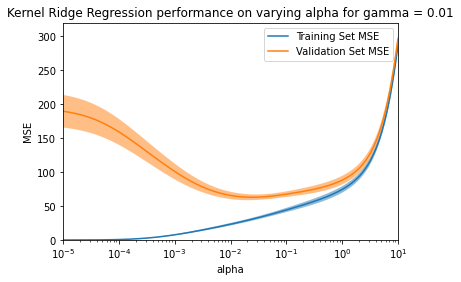

In [77]:
start_time = time.time()
krr = KernelRidge(kernel = "rbf", gamma = krr_init_params['gamma'])
extra_string = ' for gamma = ' + str(krr_init_params['gamma'])
param_grid = {"alpha": np.logspace(-5, 1, 1000)}
validation_curve('Kernel Ridge Regression', krr, XX, YY_genea, param_grid, True, extra_string, np.logspace(-5,1, 7))
print("Time taken: ", time.time() - start_time)

Tuning Gamma

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  265.3306243419647


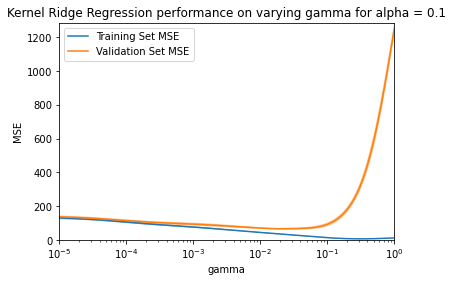

In [78]:
start_time = time.time()
krr = KernelRidge(kernel = "rbf", alpha = krr_init_params['alpha'])
extra_string = ' for alpha = ' + str(krr_init_params['alpha'])
param_grid = {"gamma": np.logspace(-5, 0, 1000)}
validation_curve('Kernel Ridge Regression', krr, XX, YY_genea, param_grid, True, extra_string, np.logspace(-5,0, 6))
print("Time taken: ", time.time() - start_time)

Predicted vs True

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.6817449291469854
Test Mean Squared Error =  71.34163422725206
Train Mean Squared Error =  34.966732236100604
Time taken:  449.6014885902405


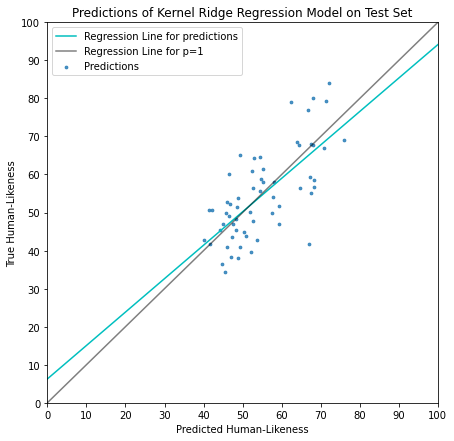

In [79]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"alpha": np.logspace(-5, 1, 50), "gamma": np.logspace(-5, 0, 50)}
krr_model = GridSearchCV(estimator = KernelRidge(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Kernel Ridge Regression', krr_model, XX, YY_genea)
print("Time taken: ", time.time() - start_time)

# Kernel Ridge Regression - Survey Labels

In [80]:
start_time = time.time()

param_grid = {"alpha": np.logspace(-10,5, 16), "gamma": np.logspace(-10, 5, 16)}
kfolds = KFold(n_splits = 5, shuffle = True)
krr = GridSearchCV(estimator = KernelRidge(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv=kfolds, verbose = 3)
krr.fit(XX_train, YY_train_survey)

krr_init_params = krr.best_params_
print("Time taken: ", time.time() - start_time)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV 1/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 2/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 3/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 4/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 5/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 1/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 2/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 3/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 4/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 5/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 1/5] END .......................alpha=1e-10, gamma=1e-08; total time=   0.0s
[CV 2/5] END .......................alpha=1e-

[CV 4/5] END .......................alpha=1e-09, gamma=1e-05; total time=   0.0s
[CV 5/5] END .......................alpha=1e-09, gamma=1e-05; total time=   0.0s
[CV 1/5] END ......................alpha=1e-09, gamma=0.0001; total time=   0.0s
[CV 2/5] END ......................alpha=1e-09, gamma=0.0001; total time=   0.0s
[CV 3/5] END ......................alpha=1e-09, gamma=0.0001; total time=   0.0s
[CV 4/5] END ......................alpha=1e-09, gamma=0.0001; total time=   0.0s
[CV 5/5] END ......................alpha=1e-09, gamma=0.0001; total time=   0.0s
[CV 1/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 2/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 3/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 4/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 5/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 1/5] END ...............

[CV 1/5] END .....................alpha=1e-08, gamma=10000.0; total time=   0.0s
[CV 2/5] END .....................alpha=1e-08, gamma=10000.0; total time=   0.0s
[CV 3/5] END .....................alpha=1e-08, gamma=10000.0; total time=   0.0s
[CV 4/5] END .....................alpha=1e-08, gamma=10000.0; total time=   0.0s
[CV 5/5] END .....................alpha=1e-08, gamma=10000.0; total time=   0.0s
[CV 1/5] END ....................alpha=1e-08, gamma=100000.0; total time=   0.0s
[CV 2/5] END ....................alpha=1e-08, gamma=100000.0; total time=   0.0s
[CV 3/5] END ....................alpha=1e-08, gamma=100000.0; total time=   0.0s
[CV 4/5] END ....................alpha=1e-08, gamma=100000.0; total time=   0.0s
[CV 5/5] END ....................alpha=1e-08, gamma=100000.0; total time=   0.0s
[CV 1/5] END .......................alpha=1e-07, gamma=1e-10; total time=   0.0s
[CV 2/5] END .......................alpha=1e-07, gamma=1e-10; total time=   0.0s
[CV 3/5] END ...............

[CV 1/5] END .......................alpha=1e-06, gamma=1e-07; total time=   0.0s
[CV 2/5] END .......................alpha=1e-06, gamma=1e-07; total time=   0.0s
[CV 3/5] END .......................alpha=1e-06, gamma=1e-07; total time=   0.0s
[CV 4/5] END .......................alpha=1e-06, gamma=1e-07; total time=   0.0s
[CV 5/5] END .......................alpha=1e-06, gamma=1e-07; total time=   0.0s
[CV 1/5] END .......................alpha=1e-06, gamma=1e-06; total time=   0.0s
[CV 2/5] END .......................alpha=1e-06, gamma=1e-06; total time=   0.0s
[CV 3/5] END .......................alpha=1e-06, gamma=1e-06; total time=   0.0s
[CV 4/5] END .......................alpha=1e-06, gamma=1e-06; total time=   0.0s
[CV 5/5] END .......................alpha=1e-06, gamma=1e-06; total time=   0.0s
[CV 1/5] END .......................alpha=1e-06, gamma=1e-05; total time=   0.0s
[CV 2/5] END .......................alpha=1e-06, gamma=1e-05; total time=   0.0s
[CV 3/5] END ...............

[CV 1/5] END .........................alpha=1e-05, gamma=0.1; total time=   0.0s
[CV 2/5] END .........................alpha=1e-05, gamma=0.1; total time=   0.0s
[CV 3/5] END .........................alpha=1e-05, gamma=0.1; total time=   0.0s
[CV 4/5] END .........................alpha=1e-05, gamma=0.1; total time=   0.0s
[CV 5/5] END .........................alpha=1e-05, gamma=0.1; total time=   0.0s
[CV 1/5] END .........................alpha=1e-05, gamma=1.0; total time=   0.0s
[CV 2/5] END .........................alpha=1e-05, gamma=1.0; total time=   0.0s
[CV 3/5] END .........................alpha=1e-05, gamma=1.0; total time=   0.0s
[CV 4/5] END .........................alpha=1e-05, gamma=1.0; total time=   0.0s
[CV 5/5] END .........................alpha=1e-05, gamma=1.0; total time=   0.0s
[CV 1/5] END ........................alpha=1e-05, gamma=10.0; total time=   0.0s
[CV 2/5] END ........................alpha=1e-05, gamma=10.0; total time=   0.0s
[CV 3/5] END ...............

[CV 3/5] END .......................alpha=0.001, gamma=1e-10; total time=   0.0s
[CV 4/5] END .......................alpha=0.001, gamma=1e-10; total time=   0.0s
[CV 5/5] END .......................alpha=0.001, gamma=1e-10; total time=   0.0s
[CV 1/5] END .......................alpha=0.001, gamma=1e-09; total time=   0.0s
[CV 2/5] END .......................alpha=0.001, gamma=1e-09; total time=   0.0s
[CV 3/5] END .......................alpha=0.001, gamma=1e-09; total time=   0.0s
[CV 4/5] END .......................alpha=0.001, gamma=1e-09; total time=   0.0s
[CV 5/5] END .......................alpha=0.001, gamma=1e-09; total time=   0.0s
[CV 1/5] END .......................alpha=0.001, gamma=1e-08; total time=   0.0s
[CV 2/5] END .......................alpha=0.001, gamma=1e-08; total time=   0.0s
[CV 3/5] END .......................alpha=0.001, gamma=1e-08; total time=   0.0s
[CV 4/5] END .......................alpha=0.001, gamma=1e-08; total time=   0.0s
[CV 5/5] END ...............

[CV 5/5] END ........................alpha=0.01, gamma=1e-05; total time=   0.0s
[CV 1/5] END .......................alpha=0.01, gamma=0.0001; total time=   0.0s
[CV 2/5] END .......................alpha=0.01, gamma=0.0001; total time=   0.0s
[CV 3/5] END .......................alpha=0.01, gamma=0.0001; total time=   0.0s
[CV 4/5] END .......................alpha=0.01, gamma=0.0001; total time=   0.0s
[CV 5/5] END .......................alpha=0.01, gamma=0.0001; total time=   0.0s
[CV 1/5] END ........................alpha=0.01, gamma=0.001; total time=   0.0s
[CV 2/5] END ........................alpha=0.01, gamma=0.001; total time=   0.0s
[CV 3/5] END ........................alpha=0.01, gamma=0.001; total time=   0.0s
[CV 4/5] END ........................alpha=0.01, gamma=0.001; total time=   0.0s
[CV 5/5] END ........................alpha=0.01, gamma=0.001; total time=   0.0s
[CV 1/5] END .........................alpha=0.01, gamma=0.01; total time=   0.0s
[CV 2/5] END ...............

[CV 2/5] END ...........................alpha=0.1, gamma=1.0; total time=   0.0s
[CV 3/5] END ...........................alpha=0.1, gamma=1.0; total time=   0.0s
[CV 4/5] END ...........................alpha=0.1, gamma=1.0; total time=   0.0s
[CV 5/5] END ...........................alpha=0.1, gamma=1.0; total time=   0.0s
[CV 1/5] END ..........................alpha=0.1, gamma=10.0; total time=   0.0s
[CV 2/5] END ..........................alpha=0.1, gamma=10.0; total time=   0.0s
[CV 3/5] END ..........................alpha=0.1, gamma=10.0; total time=   0.0s
[CV 4/5] END ..........................alpha=0.1, gamma=10.0; total time=   0.0s
[CV 5/5] END ..........................alpha=0.1, gamma=10.0; total time=   0.0s
[CV 1/5] END .........................alpha=0.1, gamma=100.0; total time=   0.0s
[CV 2/5] END .........................alpha=0.1, gamma=100.0; total time=   0.0s
[CV 3/5] END .........................alpha=0.1, gamma=100.0; total time=   0.0s
[CV 4/5] END ...............

[CV 1/5] END ........................alpha=10.0, gamma=1e-08; total time=   0.0s
[CV 2/5] END ........................alpha=10.0, gamma=1e-08; total time=   0.0s
[CV 3/5] END ........................alpha=10.0, gamma=1e-08; total time=   0.0s
[CV 4/5] END ........................alpha=10.0, gamma=1e-08; total time=   0.0s
[CV 5/5] END ........................alpha=10.0, gamma=1e-08; total time=   0.0s
[CV 1/5] END ........................alpha=10.0, gamma=1e-07; total time=   0.0s
[CV 2/5] END ........................alpha=10.0, gamma=1e-07; total time=   0.0s
[CV 3/5] END ........................alpha=10.0, gamma=1e-07; total time=   0.0s
[CV 4/5] END ........................alpha=10.0, gamma=1e-07; total time=   0.0s
[CV 5/5] END ........................alpha=10.0, gamma=1e-07; total time=   0.0s
[CV 1/5] END ........................alpha=10.0, gamma=1e-06; total time=   0.0s
[CV 2/5] END ........................alpha=10.0, gamma=1e-06; total time=   0.0s
[CV 3/5] END ...............

[CV 1/5] END ........................alpha=100.0, gamma=10.0; total time=   0.0s
[CV 2/5] END ........................alpha=100.0, gamma=10.0; total time=   0.0s
[CV 3/5] END ........................alpha=100.0, gamma=10.0; total time=   0.0s
[CV 4/5] END ........................alpha=100.0, gamma=10.0; total time=   0.0s
[CV 5/5] END ........................alpha=100.0, gamma=10.0; total time=   0.0s
[CV 1/5] END .......................alpha=100.0, gamma=100.0; total time=   0.0s
[CV 2/5] END .......................alpha=100.0, gamma=100.0; total time=   0.0s
[CV 3/5] END .......................alpha=100.0, gamma=100.0; total time=   0.0s
[CV 4/5] END .......................alpha=100.0, gamma=100.0; total time=   0.0s
[CV 5/5] END .......................alpha=100.0, gamma=100.0; total time=   0.0s
[CV 1/5] END ......................alpha=100.0, gamma=1000.0; total time=   0.0s
[CV 2/5] END ......................alpha=100.0, gamma=1000.0; total time=   0.0s
[CV 3/5] END ...............

[CV 1/5] END .....................alpha=10000.0, gamma=1e-06; total time=   0.0s
[CV 2/5] END .....................alpha=10000.0, gamma=1e-06; total time=   0.0s
[CV 3/5] END .....................alpha=10000.0, gamma=1e-06; total time=   0.0s
[CV 4/5] END .....................alpha=10000.0, gamma=1e-06; total time=   0.0s
[CV 5/5] END .....................alpha=10000.0, gamma=1e-06; total time=   0.0s
[CV 1/5] END .....................alpha=10000.0, gamma=1e-05; total time=   0.0s
[CV 2/5] END .....................alpha=10000.0, gamma=1e-05; total time=   0.0s
[CV 3/5] END .....................alpha=10000.0, gamma=1e-05; total time=   0.0s
[CV 4/5] END .....................alpha=10000.0, gamma=1e-05; total time=   0.0s
[CV 5/5] END .....................alpha=10000.0, gamma=1e-05; total time=   0.0s
[CV 1/5] END ....................alpha=10000.0, gamma=0.0001; total time=   0.0s
[CV 2/5] END ....................alpha=10000.0, gamma=0.0001; total time=   0.0s
[CV 3/5] END ...............

[CV 5/5] END ....................alpha=100000.0, gamma=100.0; total time=   0.0s
[CV 1/5] END ...................alpha=100000.0, gamma=1000.0; total time=   0.0s
[CV 2/5] END ...................alpha=100000.0, gamma=1000.0; total time=   0.0s
[CV 3/5] END ...................alpha=100000.0, gamma=1000.0; total time=   0.0s
[CV 4/5] END ...................alpha=100000.0, gamma=1000.0; total time=   0.0s
[CV 5/5] END ...................alpha=100000.0, gamma=1000.0; total time=   0.0s
[CV 1/5] END ..................alpha=100000.0, gamma=10000.0; total time=   0.0s
[CV 2/5] END ..................alpha=100000.0, gamma=10000.0; total time=   0.0s
[CV 3/5] END ..................alpha=100000.0, gamma=10000.0; total time=   0.0s
[CV 4/5] END ..................alpha=100000.0, gamma=10000.0; total time=   0.0s
[CV 5/5] END ..................alpha=100000.0, gamma=10000.0; total time=   0.0s
[CV 1/5] END .................alpha=100000.0, gamma=100000.0; total time=   0.0s
[CV 2/5] END ...............

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  269.1478898525238


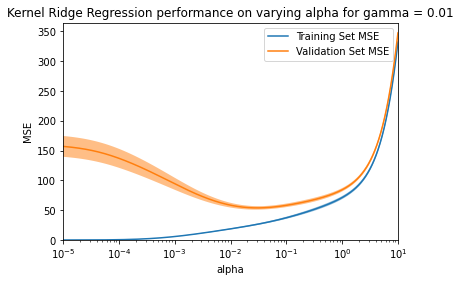

In [81]:
start_time = time.time()
krr = KernelRidge(kernel = "rbf", gamma = krr_init_params['gamma'])
extra_string = ' for gamma = ' + str(krr_init_params['gamma'])
param_grid = {"alpha": np.logspace(-5, 1, 1000)}
validation_curve('Kernel Ridge Regression', krr, XX, YY_survey, param_grid, True, extra_string, np.logspace(-5,1, 7))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  263.65577936172485


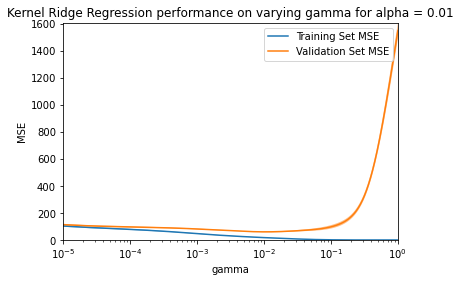

In [82]:
start_time = time.time()
krr = KernelRidge(kernel = "rbf", alpha = krr_init_params['alpha'])
extra_string = ' for alpha = ' + str(krr_init_params['alpha'])
param_grid = {"gamma": np.logspace(-5, 0, 1000)}
validation_curve('Kernel Ridge Regression', krr, XX, YY_survey, param_grid, True, extra_string, np.logspace(-5,0, 6))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.6898784316750562
Test Mean Squared Error =  59.28470876375045
Train Mean Squared Error =  25.07598438593349
Time taken:  458.63689732551575


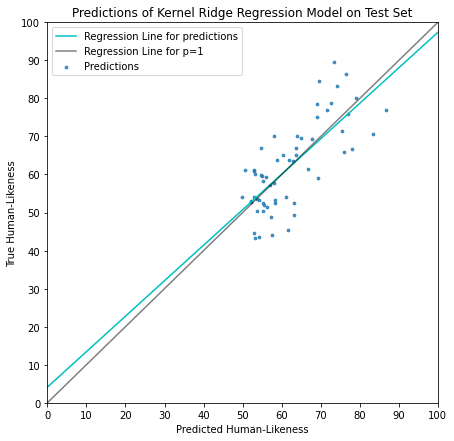

In [83]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"alpha": np.logspace(-5, 1, 50), "gamma": np.logspace(-5, 0, 50)}
krr_model = GridSearchCV(estimator = KernelRidge(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Kernel Ridge Regression', krr_model, XX, YY_survey)
print("Time taken: ", time.time() - start_time)

# Kernel Ridge Regression - Combined Labels

In [84]:
start_time = time.time()

param_grid = {"alpha": np.logspace(-10,5, 16), "gamma": np.logspace(-10, 5, 16)}
kfolds = KFold(n_splits = 5, shuffle = True)
krr = GridSearchCV(estimator = KernelRidge(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv=kfolds, verbose = 3)
krr.fit(XX_train, YY_train_combined)

krr_init_params = krr.best_params_
print("Time taken: ", time.time() - start_time)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV 1/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 2/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 3/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 4/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 5/5] END .......................alpha=1e-10, gamma=1e-10; total time=   0.0s
[CV 1/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 2/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 3/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 4/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 5/5] END .......................alpha=1e-10, gamma=1e-09; total time=   0.0s
[CV 1/5] END .......................alpha=1e-10, gamma=1e-08; total time=   0.0s
[CV 2/5] END .......................alpha=1e-

[CV 4/5] END ......................alpha=1e-09, gamma=0.0001; total time=   0.0s
[CV 5/5] END ......................alpha=1e-09, gamma=0.0001; total time=   0.0s
[CV 1/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 2/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 3/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 4/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 5/5] END .......................alpha=1e-09, gamma=0.001; total time=   0.0s
[CV 1/5] END ........................alpha=1e-09, gamma=0.01; total time=   0.0s
[CV 2/5] END ........................alpha=1e-09, gamma=0.01; total time=   0.0s
[CV 3/5] END ........................alpha=1e-09, gamma=0.01; total time=   0.0s
[CV 4/5] END ........................alpha=1e-09, gamma=0.01; total time=   0.0s
[CV 5/5] END ........................alpha=1e-09, gamma=0.01; total time=   0.0s
[CV 1/5] END ...............

[CV 5/5] END .....................alpha=1e-08, gamma=10000.0; total time=   0.0s
[CV 1/5] END ....................alpha=1e-08, gamma=100000.0; total time=   0.0s
[CV 2/5] END ....................alpha=1e-08, gamma=100000.0; total time=   0.0s
[CV 3/5] END ....................alpha=1e-08, gamma=100000.0; total time=   0.0s
[CV 4/5] END ....................alpha=1e-08, gamma=100000.0; total time=   0.0s
[CV 5/5] END ....................alpha=1e-08, gamma=100000.0; total time=   0.0s
[CV 1/5] END .......................alpha=1e-07, gamma=1e-10; total time=   0.0s
[CV 2/5] END .......................alpha=1e-07, gamma=1e-10; total time=   0.0s
[CV 3/5] END .......................alpha=1e-07, gamma=1e-10; total time=   0.0s
[CV 4/5] END .......................alpha=1e-07, gamma=1e-10; total time=   0.0s
[CV 5/5] END .......................alpha=1e-07, gamma=1e-10; total time=   0.0s
[CV 1/5] END .......................alpha=1e-07, gamma=1e-09; total time=   0.0s
[CV 2/5] END ...............

[CV 4/5] END .......................alpha=1e-06, gamma=1e-05; total time=   0.0s
[CV 5/5] END .......................alpha=1e-06, gamma=1e-05; total time=   0.0s
[CV 1/5] END ......................alpha=1e-06, gamma=0.0001; total time=   0.0s
[CV 2/5] END ......................alpha=1e-06, gamma=0.0001; total time=   0.0s
[CV 3/5] END ......................alpha=1e-06, gamma=0.0001; total time=   0.0s
[CV 4/5] END ......................alpha=1e-06, gamma=0.0001; total time=   0.0s
[CV 5/5] END ......................alpha=1e-06, gamma=0.0001; total time=   0.0s
[CV 1/5] END .......................alpha=1e-06, gamma=0.001; total time=   0.0s
[CV 2/5] END .......................alpha=1e-06, gamma=0.001; total time=   0.0s
[CV 3/5] END .......................alpha=1e-06, gamma=0.001; total time=   0.0s
[CV 4/5] END .......................alpha=1e-06, gamma=0.001; total time=   0.0s
[CV 5/5] END .......................alpha=1e-06, gamma=0.001; total time=   0.0s
[CV 1/5] END ...............

[CV 2/5] END ........................alpha=1e-05, gamma=10.0; total time=   0.0s
[CV 3/5] END ........................alpha=1e-05, gamma=10.0; total time=   0.0s
[CV 4/5] END ........................alpha=1e-05, gamma=10.0; total time=   0.0s
[CV 5/5] END ........................alpha=1e-05, gamma=10.0; total time=   0.0s
[CV 1/5] END .......................alpha=1e-05, gamma=100.0; total time=   0.0s
[CV 2/5] END .......................alpha=1e-05, gamma=100.0; total time=   0.0s
[CV 3/5] END .......................alpha=1e-05, gamma=100.0; total time=   0.0s
[CV 4/5] END .......................alpha=1e-05, gamma=100.0; total time=   0.0s
[CV 5/5] END .......................alpha=1e-05, gamma=100.0; total time=   0.0s
[CV 1/5] END ......................alpha=1e-05, gamma=1000.0; total time=   0.0s
[CV 2/5] END ......................alpha=1e-05, gamma=1000.0; total time=   0.0s
[CV 3/5] END ......................alpha=1e-05, gamma=1000.0; total time=   0.0s
[CV 4/5] END ...............

[CV 3/5] END .......................alpha=0.001, gamma=1e-09; total time=   0.0s
[CV 4/5] END .......................alpha=0.001, gamma=1e-09; total time=   0.0s
[CV 5/5] END .......................alpha=0.001, gamma=1e-09; total time=   0.0s
[CV 1/5] END .......................alpha=0.001, gamma=1e-08; total time=   0.0s
[CV 2/5] END .......................alpha=0.001, gamma=1e-08; total time=   0.0s
[CV 3/5] END .......................alpha=0.001, gamma=1e-08; total time=   0.0s
[CV 4/5] END .......................alpha=0.001, gamma=1e-08; total time=   0.0s
[CV 5/5] END .......................alpha=0.001, gamma=1e-08; total time=   0.0s
[CV 1/5] END .......................alpha=0.001, gamma=1e-07; total time=   0.0s
[CV 2/5] END .......................alpha=0.001, gamma=1e-07; total time=   0.0s
[CV 3/5] END .......................alpha=0.001, gamma=1e-07; total time=   0.0s
[CV 4/5] END .......................alpha=0.001, gamma=1e-07; total time=   0.0s
[CV 5/5] END ...............

[CV 3/5] END .......................alpha=0.01, gamma=0.0001; total time=   0.0s
[CV 4/5] END .......................alpha=0.01, gamma=0.0001; total time=   0.0s
[CV 5/5] END .......................alpha=0.01, gamma=0.0001; total time=   0.0s
[CV 1/5] END ........................alpha=0.01, gamma=0.001; total time=   0.0s
[CV 2/5] END ........................alpha=0.01, gamma=0.001; total time=   0.0s
[CV 3/5] END ........................alpha=0.01, gamma=0.001; total time=   0.0s
[CV 4/5] END ........................alpha=0.01, gamma=0.001; total time=   0.0s
[CV 5/5] END ........................alpha=0.01, gamma=0.001; total time=   0.0s
[CV 1/5] END .........................alpha=0.01, gamma=0.01; total time=   0.0s
[CV 2/5] END .........................alpha=0.01, gamma=0.01; total time=   0.0s
[CV 3/5] END .........................alpha=0.01, gamma=0.01; total time=   0.0s
[CV 4/5] END .........................alpha=0.01, gamma=0.01; total time=   0.0s
[CV 5/5] END ...............

[CV 1/5] END .......................alpha=0.1, gamma=10000.0; total time=   0.0s
[CV 2/5] END .......................alpha=0.1, gamma=10000.0; total time=   0.0s
[CV 3/5] END .......................alpha=0.1, gamma=10000.0; total time=   0.0s
[CV 4/5] END .......................alpha=0.1, gamma=10000.0; total time=   0.0s
[CV 5/5] END .......................alpha=0.1, gamma=10000.0; total time=   0.0s
[CV 1/5] END ......................alpha=0.1, gamma=100000.0; total time=   0.0s
[CV 2/5] END ......................alpha=0.1, gamma=100000.0; total time=   0.0s
[CV 3/5] END ......................alpha=0.1, gamma=100000.0; total time=   0.0s
[CV 4/5] END ......................alpha=0.1, gamma=100000.0; total time=   0.0s
[CV 5/5] END ......................alpha=0.1, gamma=100000.0; total time=   0.0s
[CV 1/5] END .........................alpha=1.0, gamma=1e-10; total time=   0.0s
[CV 2/5] END .........................alpha=1.0, gamma=1e-10; total time=   0.0s
[CV 3/5] END ...............

[CV 4/5] END ........................alpha=10.0, gamma=1e-08; total time=   0.0s
[CV 5/5] END ........................alpha=10.0, gamma=1e-08; total time=   0.0s
[CV 1/5] END ........................alpha=10.0, gamma=1e-07; total time=   0.0s
[CV 2/5] END ........................alpha=10.0, gamma=1e-07; total time=   0.0s
[CV 3/5] END ........................alpha=10.0, gamma=1e-07; total time=   0.0s
[CV 4/5] END ........................alpha=10.0, gamma=1e-07; total time=   0.0s
[CV 5/5] END ........................alpha=10.0, gamma=1e-07; total time=   0.0s
[CV 1/5] END ........................alpha=10.0, gamma=1e-06; total time=   0.0s
[CV 2/5] END ........................alpha=10.0, gamma=1e-06; total time=   0.0s
[CV 3/5] END ........................alpha=10.0, gamma=1e-06; total time=   0.0s
[CV 4/5] END ........................alpha=10.0, gamma=1e-06; total time=   0.0s
[CV 5/5] END ........................alpha=10.0, gamma=1e-06; total time=   0.0s
[CV 1/5] END ...............

[CV 1/5] END .........................alpha=100.0, gamma=1.0; total time=   0.0s
[CV 2/5] END .........................alpha=100.0, gamma=1.0; total time=   0.0s
[CV 3/5] END .........................alpha=100.0, gamma=1.0; total time=   0.0s
[CV 4/5] END .........................alpha=100.0, gamma=1.0; total time=   0.0s
[CV 5/5] END .........................alpha=100.0, gamma=1.0; total time=   0.0s
[CV 1/5] END ........................alpha=100.0, gamma=10.0; total time=   0.0s
[CV 2/5] END ........................alpha=100.0, gamma=10.0; total time=   0.0s
[CV 3/5] END ........................alpha=100.0, gamma=10.0; total time=   0.0s
[CV 4/5] END ........................alpha=100.0, gamma=10.0; total time=   0.0s
[CV 5/5] END ........................alpha=100.0, gamma=10.0; total time=   0.0s
[CV 1/5] END .......................alpha=100.0, gamma=100.0; total time=   0.0s
[CV 2/5] END .......................alpha=100.0, gamma=100.0; total time=   0.0s
[CV 3/5] END ...............

[CV 2/5] END .....................alpha=10000.0, gamma=1e-08; total time=   0.0s
[CV 3/5] END .....................alpha=10000.0, gamma=1e-08; total time=   0.0s
[CV 4/5] END .....................alpha=10000.0, gamma=1e-08; total time=   0.0s
[CV 5/5] END .....................alpha=10000.0, gamma=1e-08; total time=   0.0s
[CV 1/5] END .....................alpha=10000.0, gamma=1e-07; total time=   0.0s
[CV 2/5] END .....................alpha=10000.0, gamma=1e-07; total time=   0.0s
[CV 3/5] END .....................alpha=10000.0, gamma=1e-07; total time=   0.0s
[CV 4/5] END .....................alpha=10000.0, gamma=1e-07; total time=   0.0s
[CV 5/5] END .....................alpha=10000.0, gamma=1e-07; total time=   0.0s
[CV 1/5] END .....................alpha=10000.0, gamma=1e-06; total time=   0.0s
[CV 2/5] END .....................alpha=10000.0, gamma=1e-06; total time=   0.0s
[CV 3/5] END .....................alpha=10000.0, gamma=1e-06; total time=   0.0s
[CV 4/5] END ...............

[CV 5/5] END ....................alpha=100000.0, gamma=0.001; total time=   0.0s
[CV 1/5] END .....................alpha=100000.0, gamma=0.01; total time=   0.0s
[CV 2/5] END .....................alpha=100000.0, gamma=0.01; total time=   0.0s
[CV 3/5] END .....................alpha=100000.0, gamma=0.01; total time=   0.0s
[CV 4/5] END .....................alpha=100000.0, gamma=0.01; total time=   0.0s
[CV 5/5] END .....................alpha=100000.0, gamma=0.01; total time=   0.0s
[CV 1/5] END ......................alpha=100000.0, gamma=0.1; total time=   0.0s
[CV 2/5] END ......................alpha=100000.0, gamma=0.1; total time=   0.0s
[CV 3/5] END ......................alpha=100000.0, gamma=0.1; total time=   0.0s
[CV 4/5] END ......................alpha=100000.0, gamma=0.1; total time=   0.0s
[CV 5/5] END ......................alpha=100000.0, gamma=0.1; total time=   0.0s
[CV 1/5] END ......................alpha=100000.0, gamma=1.0; total time=   0.0s
[CV 2/5] END ...............

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  260.8435206413269


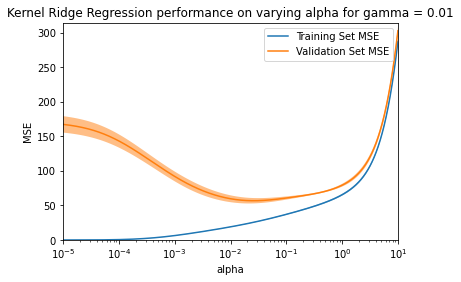

In [85]:
start_time = time.time()
krr = KernelRidge(kernel = "rbf", gamma = krr_init_params['gamma'])
extra_string = ' for gamma = ' + str(krr_init_params['gamma'])
param_grid = {"alpha": np.logspace(-5, 1, 1000)}
validation_curve('Kernel Ridge Regression', krr, XX, YY_combined, param_grid, True, extra_string, np.logspace(-5,1, 7))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  250.4157042503357


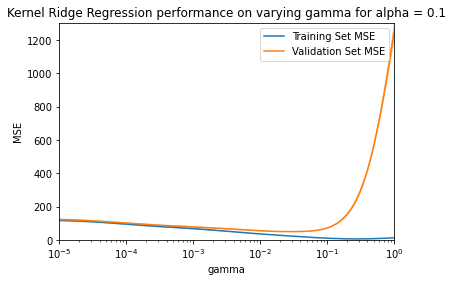

In [86]:
start_time = time.time()
krr = KernelRidge(kernel = "rbf", alpha = krr_init_params['alpha'])
extra_string = ' for alpha = ' + str(krr_init_params['alpha'])
param_grid = {"gamma": np.logspace(-5, 0, 1000)}
validation_curve('Kernel Ridge Regression', krr, XX, YY_combined, param_grid, True, extra_string, np.logspace(-5,0, 6))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.7413726035009727
Test Mean Squared Error =  52.88722472202655
Train Mean Squared Error =  22.261212169608697
Time taken:  442.1992244720459


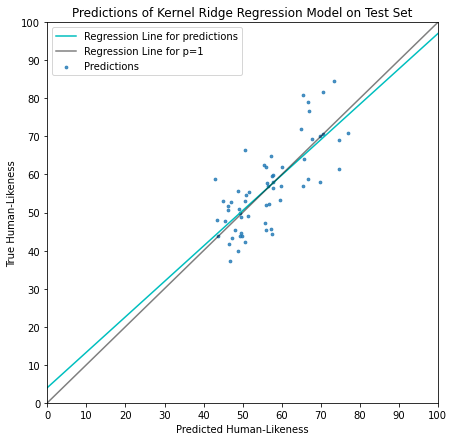

In [87]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"alpha": np.logspace(-5, 1, 50), "gamma": np.logspace(-5, 0, 50)}
krr_model = GridSearchCV(estimator = KernelRidge(kernel = "rbf"), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('Kernel Ridge Regression', krr_model, XX, YY_combined)
print("Time taken: ", time.time() - start_time)

# kNN Regression - GENEA Labels

Tune n_neighbors for weights = "uniform"

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  2.7482824325561523


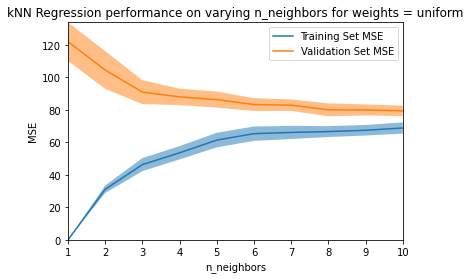

In [44]:
start_time = time.time()
knn = KNeighborsRegressor(weights = 'uniform')
extra_string = ' for weights = uniform'
param_grid = {"n_neighbors": np.arange(1,11,1)}
validation_curve('kNN Regression', knn, XX, YY_genea, param_grid, False, extra_string, np.arange(1,11,1))
print("Time taken: ", time.time() - start_time)

Tune n_neighbors for weights = "distance"

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  2.8350582122802734


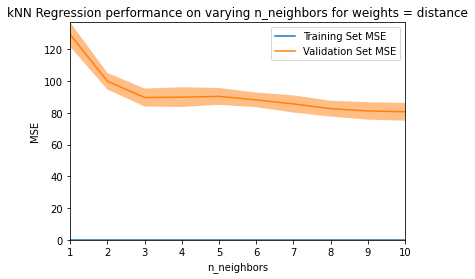

In [45]:
start_time = time.time()
knn = KNeighborsRegressor(weights = 'distance')
extra_string = ' for weights = distance'
param_grid = {"n_neighbors": np.arange(1,11,1)}
validation_curve('kNN Regression', knn, XX, YY_genea, param_grid, False, extra_string, np.arange(1,11,1))
print("Time taken: ", time.time() - start_time)

Predicted vs True

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.6103362045012505
Test Mean Squared Error =  81.78940384763179
Train Mean Squared Error =  2.6961265743419697e-10
Time taken:  3.478869915008545


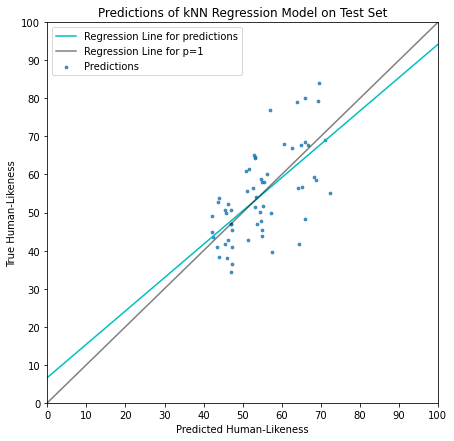

In [46]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"n_neighbors": np.arange(1,11,1), "weights": ["uniform", "distance"]}
knn_model = GridSearchCV(estimator = KNeighborsRegressor(), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('kNN Regression', knn_model, XX, YY_genea)
print("Time taken: ", time.time() - start_time)

# kNN Regression - Survey Labels

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  2.527989149093628


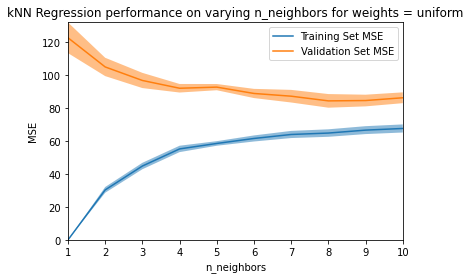

In [47]:
start_time = time.time()
knn = KNeighborsRegressor(weights = 'uniform')
extra_string = ' for weights = uniform'
param_grid = {"n_neighbors": np.arange(1,11,1)}
validation_curve('kNN Regression', knn, XX, YY_survey, param_grid, False, extra_string, np.arange(1,11,1))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  2.5132803916931152


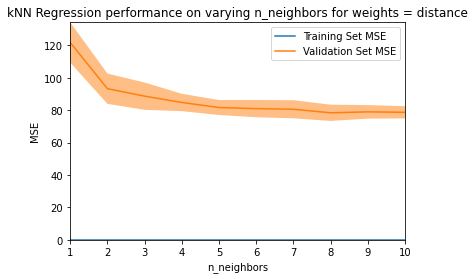

In [48]:
start_time = time.time()
knn = KNeighborsRegressor(weights = 'distance')
extra_string = ' for weights = distance'
param_grid = {"n_neighbors": np.arange(1,11,1)}
validation_curve('kNN Regression', knn, XX, YY_survey, param_grid, False, extra_string, np.arange(1,11,1))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.6149913179132535
Test Mean Squared Error =  73.30087784921055
Train Mean Squared Error =  2.7438273115133956e-10
Time taken:  3.569709300994873


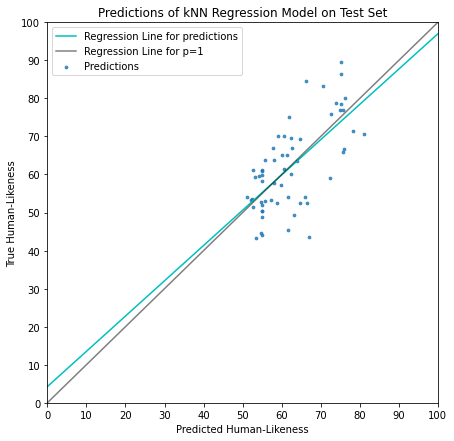

In [49]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"n_neighbors": np.arange(1,11,1), "weights": ["uniform", "distance"]}
knn_model = GridSearchCV(estimator = KNeighborsRegressor(), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('kNN Regression', knn_model, XX, YY_survey)
print("Time taken: ", time.time() - start_time)

# kNN Regression - Combined Labels

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  2.7234675884246826


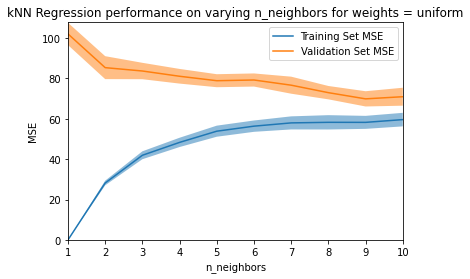

In [50]:
start_time = time.time()
knn = KNeighborsRegressor(weights = 'uniform')
extra_string = ' for weights = uniform'
param_grid = {"n_neighbors": np.arange(1,11,1)}
validation_curve('kNN Regression', knn, XX, YY_combined, param_grid, False, extra_string, np.arange(1,11,1))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Time taken:  2.6128177642822266


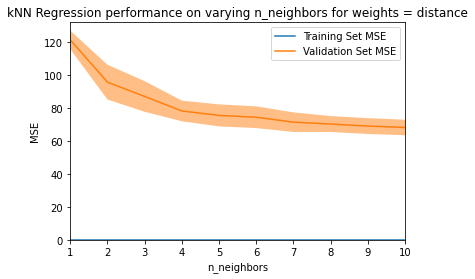

In [51]:
start_time = time.time()
knn = KNeighborsRegressor(weights = 'distance')
extra_string = ' for weights = distance'
param_grid = {"n_neighbors": np.arange(1,11,1)}
validation_curve('kNN Regression', knn, XX, YY_combined, param_grid, False, extra_string, np.arange(1,11,1))
print("Time taken: ", time.time() - start_time)

Fold  1 / 5  Complete.
Fold  2 / 5  Complete.
Fold  3 / 5  Complete.
Fold  4 / 5  Complete.
Fold  5 / 5  Complete.
Pearson Correlation Coefficient = 0.6202834120589054
Test Mean Squared Error =  75.31739875576595
Train Mean Squared Error =  1.8738434413937503e-10
Time taken:  3.452991485595703


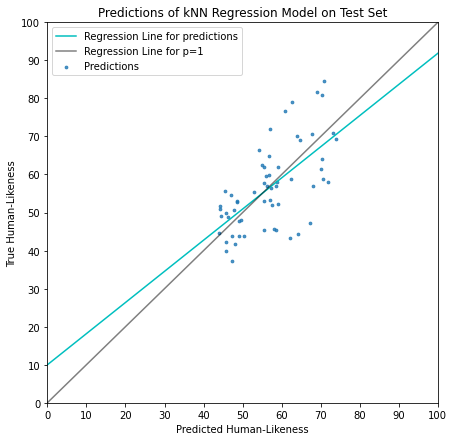

In [52]:
start_time = time.time()
kfolds = KFold(n_splits = 5, shuffle = True)
param_grid = {"n_neighbors": np.arange(1,11,1), "weights": ["uniform", "distance"]}
knn_model = GridSearchCV(estimator = KNeighborsRegressor(), param_grid = param_grid, scoring = "neg_mean_squared_error", cv = kfolds)
predicted_vs_true('kNN Regression', knn_model, XX, YY_combined)
print("Time taken: ", time.time() - start_time)

# Variances

In [88]:
print('GENEA Variance: ',np.var(YY_genea))
print('Survey Variance: ',np.var(YY_survey))
print('Combined Variance: ',np.var(YY_combined))

print('GENEA Mean: ',np.mean(YY_genea))
print('Survey Mean: ',np.mean(YY_survey))
print('Combined Mean: ',np.mean(YY_combined))

GENEA Variance:  136.96120405681992
Survey Variance:  130.80914166666668
Combined Variance:  123.7083329887211
GENEA Mean:  54.525866279906495
Survey Mean:  62.004999999999995
Combined Mean:  56.56517964142692


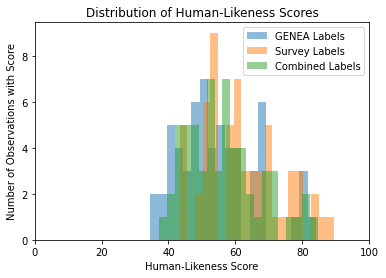

In [91]:
plt.hist(YY_genea, bins = 20, label='GENEA Labels', alpha=0.5)
plt.hist(YY_survey, bins = 20, label='Survey Labels', alpha=0.5)
plt.hist(YY_combined, bins = 20, label='Combined Labels', alpha=0.5)
plt.xlim(0,100)
plt.xlabel("Human-Likeness Score")
plt.ylabel("Number of Observations with Score")
plt.title("Distribution of Human-Likeness Scores")
plt.legend()